# Visualizing the results of schedulers simulation

## Define needed functions and variables

In [2]:
import matplotlib.pyplot as plt
import sys
import json
import numpy as np
import numpy.random as random
import itertools
sys.path.append('../')  # Include parent directory in module search
sys.path.append('../../')
from schedule_simulator_core.core import Distribution
from schedule_simulator_core.utils import convert_time
from schedule_simulator_core.simulation_presets import GpuNetworkSim
from schedule_simulator_core.schedulers import FIFOScheduler, TopologicalPriorityScheduler
from schedule_simulator_core.DAGs import serialize_dag, deserialize_dag, HomogeneousLinearDAG, \
LinearDag, LayerFactory

def npa(li):
    # To ensure silly overflow errors do not occur or at least reduce the chance.
    return np.array(li, dtype="float64")

#### Define schedulers

In [3]:
schedulers = [FIFOScheduler(), TopologicalPriorityScheduler(preemptive=False),
              TopologicalPriorityScheduler(preemptive=True)]

#### Visualization function

In [4]:
# """
# This block tries to make a generic grid plot function.
# It is still under development so do not use it.
# """

def group_results_by(results, variables_list):
    """
    :param results: The results dictionary.
    :param variables_list: A list of results keys that will be used to group. You can also specify a (key, [values])
    tuple instead of just the key to indicate that you only want those values to create groups.
    :return: dict(key=group tuple, value=a subset of the results dictionary values that belong to
    this group. the format of the results dict stays the same. This means that a group result of this function
    can be fed again to the same function to further group the data.
    """
    groups = dict()
    # Add prespecified groups if they exist
    group_variables_prespecified_groups = dict()
    for i, variable in enumerate(variables_list):
        if isinstance(variable, tuple):
            # Did we get a tuple with an already specified list of groups ?
            groups[variable[0]] = tuple(variable[1])
            variables_list[i] = variable[0]
    # Generate variable groups if they haven't already been specified
    none_i = 0
    for variable in variables_list:
        # If key is already in groups that means a prespecified group was passed no need to generate
        if variable in groups:
            continue
        groups[variable] = set()
        for value in results[variable]:
            groups[variable].add(value)
        groups[variable] = list(groups[variable])
        groups[variable].sort()
        groups[variable] = tuple(groups[variable])
    # Generate all possible combinations of the above groups
    groups_combinations = list(itertools.product(*groups.values()))
    # Add each record to its respected group
    grouped_results = dict()
    for combination in groups_combinations:
        template = dict()
        for key in results.keys():
            template[key] = list()
        grouped_results[(tuple(variables_list), combination)] = template
    for record_i in range(len(results.values().__iter__().__next__())):
        group = list()
        for group_variable in variables_list:
            group.append(results[group_variable][record_i])
        # Do we want to record this group ?
        group_key = tuple(group)
        if (tuple(variables_list), group_key) in grouped_results:
            for key in results.keys():
                grouped_results[(tuple(variables_list), group_key)][key].append(results[key][record_i])
    return grouped_results


# def plot_grid(results, plotting_function, plotting_function_args, row_variable=None, column_variable=None,
#               label_length=20, subplot_size=None, title=None, save=False):
#     if subplot_size is None:
#         subplot_size = (5, 5)
#     figure = None
#     subplot_i = 1
#     if column_variable is None:
#         column_groups = {None: results}
#     else:
#         column_groups = group_results_by(results, [column_variable])
#     for column_group, column_data in column_groups.items():
#         if row_variable is None:
#             row_groups = {None: results}
#         else:
#             row_groups = group_results_by(column_data, [row_variable])
#         if figure is None:
#             figsize = subplot_size[0] * len(row_groups), subplot_size[1] * len(column_groups)
#             figure = plt.figure(figsize=figsize)
#         for row_group, subplot_data in row_groups.items():
#             print("Col", column_group)
#             print("Row", row_group)
#             plt.subplot(len(column_groups), len(row_groups), subplot_i)
#             sub_title = ""
#             if row_group is not None:
#                 sub_title += "{}: {} ".format(
#                     trim(row_group[0][0], label_length // 2),
#                     trim(row_group[1][0], label_length // 2))
#             if column_group is not None:
#                 sub_title += "{}: {} ".format(
#                     trim(column_group[0][0], label_length // 2),
#                     trim(column_group[1][0], label_length // 2))
#             plt.title(sub_title)
#             plotting_function(subplot_data, **plotting_function_args)
#             subplot_i += 1
#     if title is not None:
#         plt.suptitle(title)
#     if save:
#         plt.savefig("{}.png".format(title))
#     return figure

# def violin_plot(results, x, y):
#     """
#     This method plots the distributions of a $list$ variable y and how it changes with x
#     """
#     fig = plt.figure()
#     # Add 0 to empty lists so that they are parsed
#     ydata = list()
#     for li in results[y]:
#         if len(li) == 0:
#             ydata.append([0])
#         else:
#             ydata.append(li)
#     plt.violinplot(ydata, positions=results[x])
#     return fig

# def line_plot(results, x, y,line_variable=None,
#               annotation_variable=None, annotation_only_for_line_groups=None, annotation_step=1):
#     pass

# violin_plot_args = dict(x="comm_units_scaling_rate", y="$list$forward_pass_gaps_durations")
# b = plot_grid(summary["results"], violin_plot, violin_plot_args, row_variable="network_scheduler",
#               column_variable="comm_units_scaling_rate")

In [5]:
from schedule_simulator_core.utils import trim
def line_plot_grid(results, x, y, line_variable=None, row_variable=None, column_variable=None,
                   annotation_variable=None, annotation_only_for_line_groups=None, annotation_step=1,
                   title=None, save=False, subplot_size=None, label_length=20):
    """
    This method helps visualize up to 6 variables at once using a simple grid of line_plots.
    :param results: The simulation group results dictionary. Should be in the format of
    dict(key=variable_name, value=list_of_variable_values_in_all_simulations)
    :param x: the variable name to represent on the x axis
    :param y: the variable name to represent on the y axis
    :param annotation_variable: The variable name to annotate the x,y points with
    :param line_variable: The variable name to use to differentiate between different lines with
    or None to plot all data using one line. Should be used with discrete variables
    :param row_variable: The variable name to use to differentiate between different subplots in a row
    or None to plot all data using one row. Should be used with discrete variables
    :param column_variable: The variable name to use to differentiate between different subplots in a column
    or None to plot all data using one column. Should be used with discrete variables
    Basically the line,row and column variables are used to create groups of data which is why they should be
    discrete. There is no current support for grouping continuous data so if they are passed a continues
    variable, each value will be treated as its own group. The three variables can also be passed a tuple
    (variable_name, [list_of_values]) to only plot specific groups or specific values of that variable.
    :param annotation_only_for_line_values: A list of the line groups that we should annotate. If set to None
    then all line groups will be annotated
    :param annotation_step: Should we annotate each xy point? or should we skip some?
    :param title: The title of the graph displayed above
    :param save: Whether we should save this plot to a file or not
    :param subplot_size: The size in (width, height) of a single subplot (cell) in the grid
    """
    group_variables = dict(r=row_variable, c=column_variable, l=line_variable)
    groups = dict()
    # Add prespecified groups if they exist
    group_variables_prespecified_groups = dict()
    for key,value in group_variables.items():
        if isinstance(value, tuple):
            # Did we get a tuple with an already specified list of groups ?
            groups[key] = tuple(value[1])
            group_variables[key] = value[0]
    # Generate variable groups if they haven't already been specified
    for key,value in group_variables.items():
        # If key is already in groups that means a prespecified group was passed no need to generate
        if key in groups:
            continue
        # If value is None then we do not want to generate groups for this variable
        if value is None:
            groups[key] = (None,)
            continue
        groups[key] = set()
        for value in results[value]:
            groups[key].add(value)
        groups[key] = list(groups[key])
        groups[key].sort()
        groups[key] = tuple(groups[key])
    # Generate all possible combinations of the above groups
    groups_combinations = list(itertools.product(groups["r"], groups["c"], groups["l"]))
    results_grouped_indices = dict()
    for combination in groups_combinations:
        results_grouped_indices[combination] = list()
    # Add each record index to its respected group
    for i in range(len(results[x])):
        group = list()
        for group_variable in group_variables.values():
            if group_variable is None:
                group.append(None)
            else:
                group.append(results[group_variable][i])
        # Do we want to record this group ?
        group_key = tuple(group)
        if group_key in results_grouped_indices:
            results_grouped_indices[group_key].append(i)
    # Start plotting
    if subplot_size is None:
        subplot_size = (5,5)
    figsize = subplot_size[0]*len(groups["r"]), subplot_size[1]*len(groups["c"])
    figure = plt.figure(figsize=figsize)
    subplot_i = 1
    for column_group in groups["c"]:
        for row_group in groups["r"]:
            plt.subplot(len(groups["c"]), len(groups["r"]), subplot_i)
            sub_title = ""
            if row_group is not None:
                sub_title += "{}: {} ".format(
                    trim(group_variables["r"],label_length//2),
                    trim(row_group,label_length//2))
            if column_group is not None:
                sub_title += "{}: {} ".format(
                    trim(group_variables["c"],label_length//2),
                    trim(column_group,label_length//2))
            plt.title(sub_title)
            has_annotated = False
            for line_group in groups["l"]:
                # We want to get all x,y data that matches the current row,column,line group
                filtered_x = [results[x][record_i] for record_i in 
                              results_grouped_indices[(row_group, column_group, line_group)]]
                filtered_y = [results[y][record_i] for record_i in 
                              results_grouped_indices[(row_group, column_group, line_group)]]
                plt.plot(filtered_x, filtered_y, marker="o", label=trim(line_group,label_length))
                if annotation_variable is not None and \
                (annotation_only_for_line_groups is None or line_group in annotation_only_for_line_groups):
                    filtered_annotations = [results[annotation_variable][record_i] for record_i in 
                                            results_grouped_indices[(row_group, column_group, line_group)]]
                    for i in range(0, len(filtered_annotations), annotation_step):
                        plt.annotate(filtered_annotations[i], (filtered_x[i], filtered_y[i]))
                    has_annotated = True
            if has_annotated:
                plt.plot([], [], ' ', label=trim("Annot: {}".format(annotation_variable), label_length))
            if line_group is not None or has_annotated:
                plt.legend()
            plt.xlabel(x)
            plt.ylabel(y)
            subplot_i += 1
    if title is not None:
        plt.suptitle(title)
    if save:
        plt.savefig("{}.png".format(title))
    return figure

In [6]:
def violin_plot_grid(results, x, y, row_variable=None, column_variable=None, bins=None,
                     title=None, save=False, subplot_size=None, label_length=20):
    group_variables = dict(r=row_variable, c=column_variable)
    groups = dict()
    # Add prespecified groups if they exist
    group_variables_prespecified_groups = dict()
    for key,value in group_variables.items():
        if isinstance(value, tuple):
            # Did we get a tuple with an already specified list of groups ?
            groups[key] = tuple(value[1])
            group_variables[key] = value[0]
    # Generate variable groups if they haven't already been specified
    for key,value in group_variables.items():
        # If key is already in groups that means a prespecified group was passed no need to generate
        if key in groups:
            continue
        # If value is None then we do not want to generate groups for this variable
        if value is None:
            groups[key] = (None,)
            continue
        groups[key] = set()
        for value in results[value]:
            groups[key].add(value)
        groups[key] = list(groups[key])
        groups[key].sort()
        groups[key] = tuple(groups[key])
    # Generate all possible combinations of the above groups
    groups_combinations = list(itertools.product(groups["r"], groups["c"]))
    results_grouped_indices = dict()
    for combination in groups_combinations:
        results_grouped_indices[combination] = list()
    # Add each record index to its respected group
    for i in range(len(results[x])):
        group = list()
        for group_variable in group_variables.values():
            if group_variable is None:
                group.append(None)
            else:
                group.append(results[group_variable][i])
        # Do we want to record this group ?
        group_key = tuple(group)
        if group_key in results_grouped_indices:
            results_grouped_indices[group_key].append(i)
    # Start plotting
    if subplot_size is None:
        subplot_size = (5,5)
    figsize = subplot_size[0]*len(groups["r"]), subplot_size[1]*len(groups["c"])
    figure = plt.figure(figsize=figsize)
    subplot_i = 1
    for column_group in groups["c"]:
        for row_group in groups["r"]:
            plt.subplot(len(groups["c"]), len(groups["r"]), subplot_i)
            sub_title = ""
            if row_group is not None:
                sub_title += "{}: {} ".format(
                    trim(group_variables["r"],label_length//2),
                    trim(row_group,label_length//2))
            if column_group is not None:
                sub_title += "{}: {} ".format(
                    trim(group_variables["c"],label_length//2),
                    trim(column_group,label_length//2))
            plt.title(sub_title)
            # We want to get all x,y data that matches the current row,column,line group
            filtered_x = [results[x][record_i] for record_i in 
                          results_grouped_indices[(row_group, column_group)]]
            filtered_y = [results[y][record_i] for record_i in 
                          results_grouped_indices[(row_group, column_group)]]
            if bins is not None:
                bin_width = len(filtered_x) // bins
                bin_widths = [bin_width]*bins
                if len(filtered_x) % bins != 0:
                    bin_widths[-1] = len(filtered_x) - bin_width*(bins-1)
                new_filtered_x = list()
                new_filtered_y = list()
                i = 0
                for bin_width in bin_widths:
                    bin_x = list()
                    bin_y = list()
                    for j in range(bin_width):
                        bin_x.append(filtered_x[i])
                        bin_y.extend(filtered_y[i])
                        i += 1
                    bin_x = sum(bin_x)/len(bin_x)
                    new_filtered_x.append(bin_x)
                    new_filtered_y.append(bin_y)
                filtered_x = new_filtered_x
                filtered_y = new_filtered_y
            # Add 0 to empty lists so that they are parsed
            ydata = list()
            for li in filtered_y:
                if len(li) == 0:
                    ydata.append([0])
                else:
                    ydata.append(li)
            width = (np.max(filtered_x) - np.min(filtered_x)) / len(filtered_x)
            plt.violinplot(ydata, positions=filtered_x, showmedians=True, widths=width)
            plt.xlabel(x)
            plt.ylabel(y.replace("$list$", ""))
            subplot_i += 1
    if title is not None:
        plt.suptitle(title)
    if save:
        plt.savefig("{}.png".format(title))
    return figure

#### Define custom metrics

In [7]:
def add_comp_to_comm_ratio(results):
    """
    The total computational units executed / total communication units executed in all of the simulation.
    This is dependent on the dag as well as the number of batches as well as the rates.
    """
    comp_durations = npa(results["comp_units.sum"]) * npa(results["batch_size"]) / npa(results["gpu_rate"])
    comm_durations = npa(results["comm_units.sum"]) / npa(results["network_rate"])
    results["comp_to_comm_ratio"] = list(comp_durations/comm_durations)

def add_hypothetical_scheduler(results, time_calc_function, scheduler_name,
                               base_scheduler="TopologicalPriorityScheduler:Preemptive"):
    last_sim_index = max(results["sim_index"])
    grouped_results = group_results_by(results, ["network_scheduler"])
    base_scheduler_results = grouped_results[(("network_scheduler",), (base_scheduler,))]
    for record_i in range(len(base_scheduler_results["sim_index"])):
        for key in results.keys():
            if key == "sim_index":
                value = base_scheduler_results[key][record_i] + last_sim_index
            elif key == "total_time_steps":
                value = time_calc_function(base_scheduler_results, record_i)
            elif key == "network_scheduler":
                value = scheduler_name
            else:
                value = base_scheduler_results[key][record_i]
            results[key].append(value)

def add_hypothetical_perfect_scheduler(results):
    def calc_func(sr, i):
        return sr["comp_units.sum"][i] * sr["batch_size"][i] * sr["n_of_batches"][i] / sr["gpu_rate"][i]
    add_hypothetical_scheduler(results, calc_func, "PerfectScheduler")
            
def add_hypothetical_semiperfect_scheduler(results):
    def calc_func(sr, i):
        return sr["total_time_steps"][i] - sum(sr["$list$forward_pass_gaps_durations"][i])
    add_hypothetical_scheduler(results, calc_func, "SemiperfectScheduler")

def normalize_over(results, stat_to_normalize, grouping_stat, reference_grouping_stat_value, reverse=False):
    grouping_stat_indices = dict()
    for i, grouping_stat_value in enumerate(results[grouping_stat]):
        if grouping_stat_value in grouping_stat_indices:
            grouping_stat_indices[grouping_stat_value].append(i)
        else:
            grouping_stat_indices[grouping_stat_value] = [i]
    reference_indices = grouping_stat_indices[reference_grouping_stat_value]
    normalized_stat = [0 for _ in range(len(results[stat_to_normalize]))]
    for group_indices in grouping_stat_indices.values():
        for i, ii in enumerate(group_indices):
            if reverse:
                normalized_stat[ii] = results[stat_to_normalize][reference_indices[i]] / results[stat_to_normalize][ii]
            else:
                normalized_stat[ii] = results[stat_to_normalize][ii] / results[stat_to_normalize][reference_indices[i]]
    return normalized_stat

def add_network_scheduler_speedup_over_fifo(results):
    """
    Total time of fifo scheduler / total time of other scheduler
    """
    results["speedup_over_fifo"] = normalize_over(results, "total_time_steps", "network_scheduler", "FIFOScheduler", reverse=True)

def format_variable(results, variable_name, format_str):
    formatted_variable = list()
    for value in results[variable_name]:
        formatted_variable.append(format_str.format(value))
    return formatted_variable

def translate_values(results, variable_name, replace_dict):
    translated_variable = list()
    for value in results[variable_name]:
        if value in replace_dict:
            translated_variable.append(replace_dict[value])
        else:
            translated_variable.append(value)
    return translated_variable

def scale_time(results, variable_name, time_unit="s", scaling_lists=False):
    to_scale = results[variable_name]
    scaled = list()
    if scaling_lists:
        for to_scale_list in to_scale:
            scaled_list = list()
            for value in to_scale_list:
                scaled_list.append(convert_time(value, "ns", time_unit))
            scaled.append(scaled_list)
    else:
        for value in to_scale:
            scaled.append(convert_time(value, "ns", time_unit))
    return scaled

def reduce_list(results, variable_name, reduce_function):
    reduced_info = list()
    for li in results[variable_name]:
        reduced_info.append(reduce_function(li))
    return reduced_info

## VGG16 simulation

Run simulation

In [95]:
# Load VGG16 Dag
dag_name = "DenseNet121_gpu_tensorflow_layer_name_mapping"
title = dag_name
with open("../model_extraction/dags/{}.dag".format(dag_name)) as dag_file:
    base_dag = deserialize_dag(dag_file.read())

bandwidths = list(np.arange(0.1, 2.1, 0.1)*1e3)
summary = GpuNetworkSim.run_group(network_bandwidth= bandwidths,
                                  gpu_scheduler=FIFOScheduler(),
                                  dag=base_dag,
                                  network_scheduler=schedulers,
                                  batch_size=1,
                                  n_of_batches=10,
                                  clear_output=True,
                                  number_of_processes=7,
                                  save_chrome_traces=False,
                                  include_gaps=True,
                                  join_traces_in_one_file=True,
                                  include_util_in_trace=False,
                                  output_file_name=title,
                                 )

Constant arguments: {'dag', 'gpu_scheduler', 'n_of_batches', 'batch_size'}
Variable arguments: {'network_bandwidth', 'network_scheduler'}
----------------------------------------------------------------------------------------------------
progress            : 100.00%
successful_sims     : 60 /60 
failed_sims         : 0  /60 
-------------------------------------------- Processes ---------------------------------------------
pid                 : 5584       8580       14848      14228      7692       12896      15868      
sim_index           : 55         59         56         57         58         54         46         
sims_processed      : 10         8          9          8          8          10         7          
network_bandwidth   : 1900.000.. 2000.0     1900.000.. 2000.0     2000.0     1900.000.. 1600.0     
gpu_scheduler       : FIFOSche.. FIFOSche.. FIFOSche.. FIFOSche.. FIFOSche.. FIFOSche.. FIFOSche.. 
network_scheduler   : Topologi.. Topologi.. Topologi.. FIFOSche.. Topo

File IO

In [96]:
# Load simulations results from file if it exists already.
# with open("GpuNetworkSim_07-17-16-25.simgroup.json") as file:
#     summary = json.load(file)

Manipulate results & add other metrics

In [97]:
results = summary["results"]
# Compute compound metrics
add_comp_to_comm_ratio(results)
add_network_scheduler_speedup_over_fifo(results)
batches_ = npa(results["n_of_batches"]) - 1
results["forward_pass_gap_sum"] = list(npa(reduce_list(results, "$list$forward_pass_gaps_durations", sum)) / batches_)
results["gpu_gap_sum"] = list(npa(reduce_list(results, "$list$gpu_gaps_durations", sum)) / batches_)
results["forward_pass_gap_count"] = list(npa(reduce_list(results, "$list$forward_pass_gaps_durations", len)) / batches_)
results["gpu_gap_count"] = list(npa(reduce_list(results, "$list$gpu_gaps_durations", len)) / batches_)
# Scale down time values
unit = "s"
for key in ["$list$forward_pass_gaps_durations", "$list$gpu_gaps_durations", "total_time_steps", 
           "forward_pass_gap_sum", "gpu_gap_sum"]:
    scaling_lists = key.startswith("$list$")
    new_name = key.replace("$list$","") if scaling_lists else key
    new_name = "{}({})".format(new_name, unit)
    results[new_name] = scale_time(results, key, unit, scaling_lists)
# Format values and shorten names
short_sch_names = {"FIFOScheduler": "FIFO", "TopologicalPriorityScheduler:Non-preemptive": "TP",
                  "TopologicalPriorityScheduler:Preemptive": "TP-Pre"}
results["sch"] = translate_values(results,"network_scheduler", short_sch_names)
results["Bandwidth(Mbps)"] = format_variable(results,"network_bandwidth", "{:.0f}")
results["network_bandwidth_gbps"] = list(npa(results["network_bandwidth"]) / 1e3)
results["Bandwidth(Gbps)"] = format_variable(results,"network_bandwidth_gbps", "{:.0f}")

Visualize

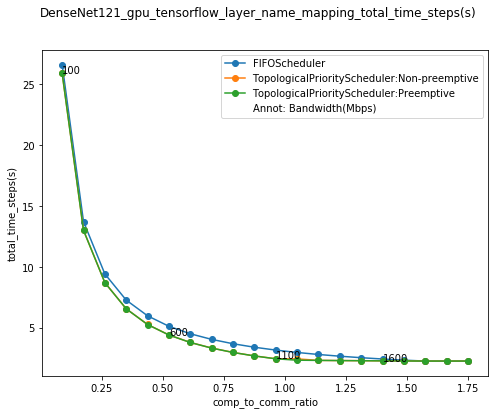

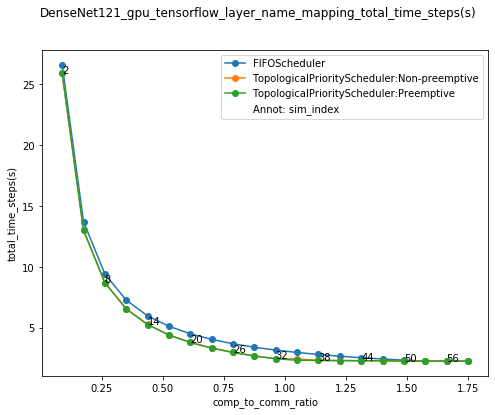

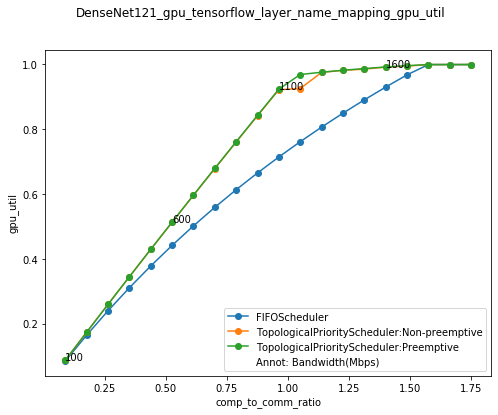

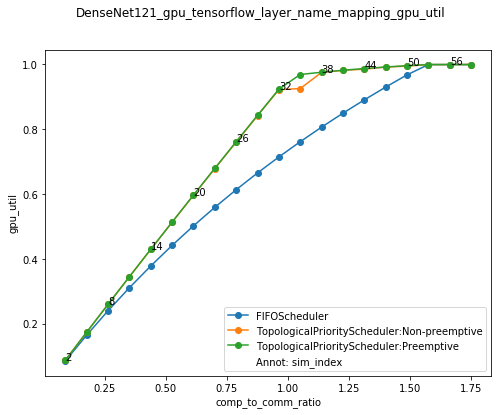

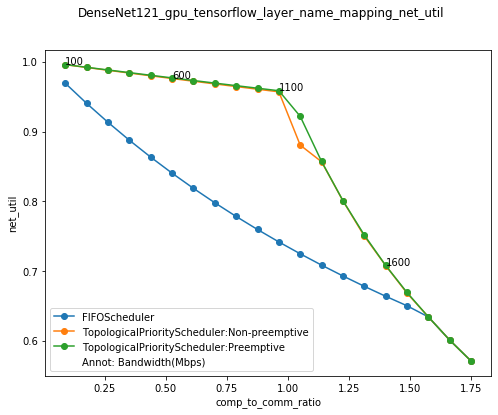

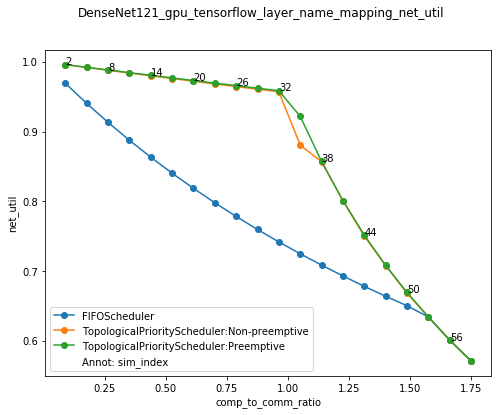

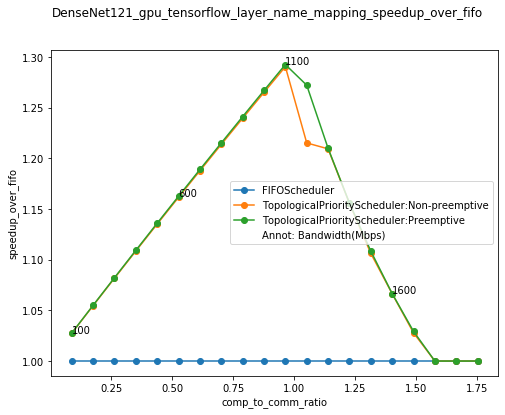

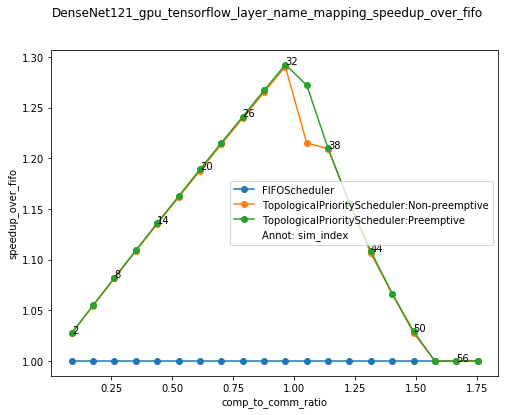

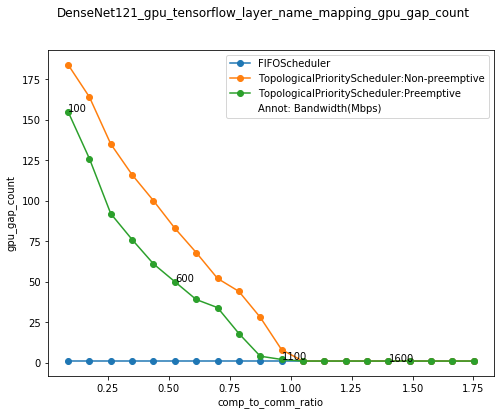

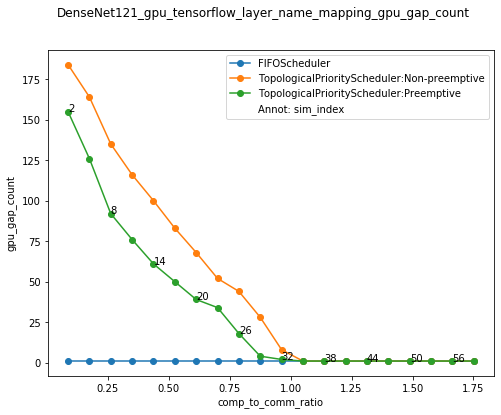

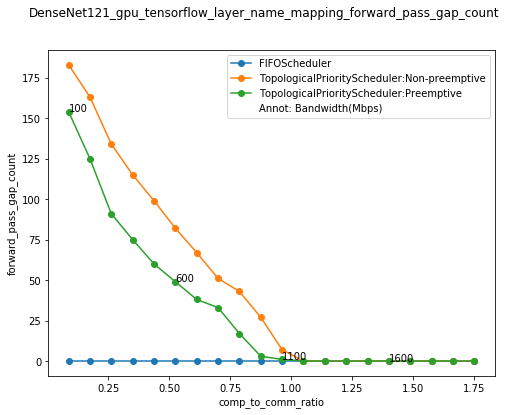

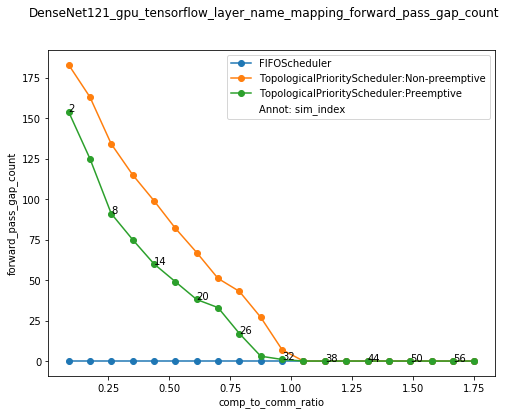

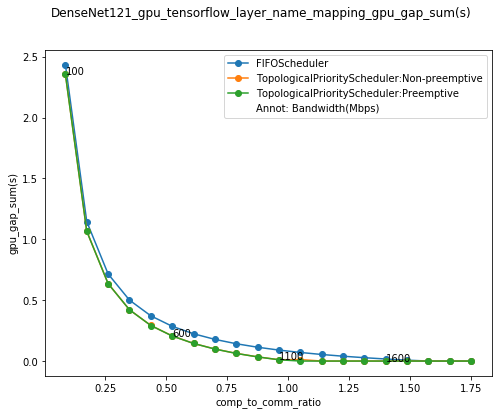

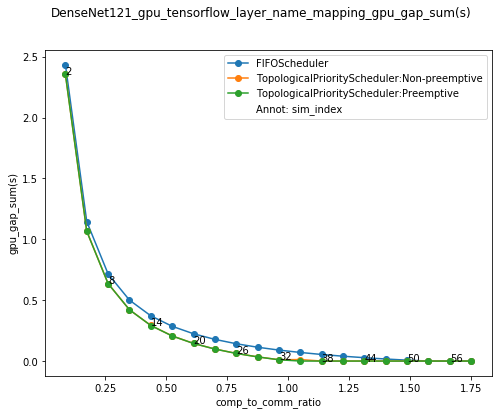

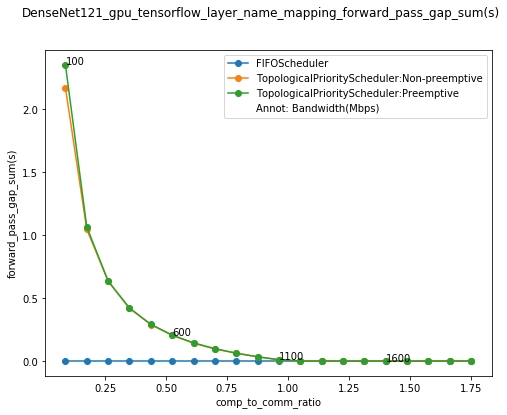

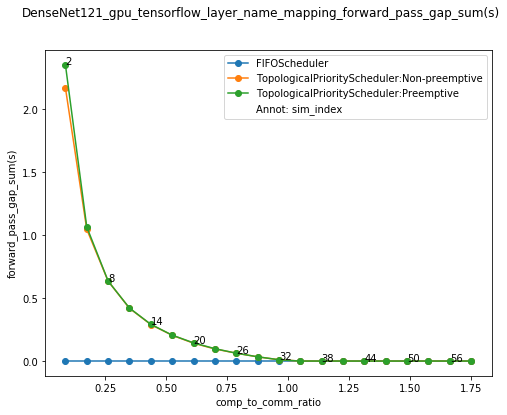

In [98]:
from matplotlib.backends.backend_pdf import PdfPages
file = PdfPages("{}_visualizaton.pdf".format(title))
for y in ["total_time_steps(s)", "gpu_util","net_util","speedup_over_fifo",
          "gpu_gap_count","forward_pass_gap_count", "gpu_gap_sum(s)","forward_pass_gap_sum(s)"]:
    results = summary["results"]
    f = line_plot_grid(results, title="{}_{}".format(title, y), save=False,
                       x="comp_to_comm_ratio",
                       y=y,
                       line_variable="network_scheduler",
                       annotation_variable= "Bandwidth(Mbps)",
                       annotation_only_for_line_groups=["TopologicalPriorityScheduler:Preemptive"],
                       annotation_step=5,
                       label_length=float("inf"),
                       subplot_size=(8,6)
                      )
    file.savefig(f)
    f = line_plot_grid(results, title="{}_{}".format(title, y), save=False,
                       x="comp_to_comm_ratio",
                       y=y,
                       line_variable="network_scheduler",
                       annotation_variable= "sim_index",
                       annotation_step=2,
                       annotation_only_for_line_groups=["TopologicalPriorityScheduler:Preemptive"],
                       label_length=float("inf"),
                       subplot_size=(8,6)
                      )
    file.savefig(f)

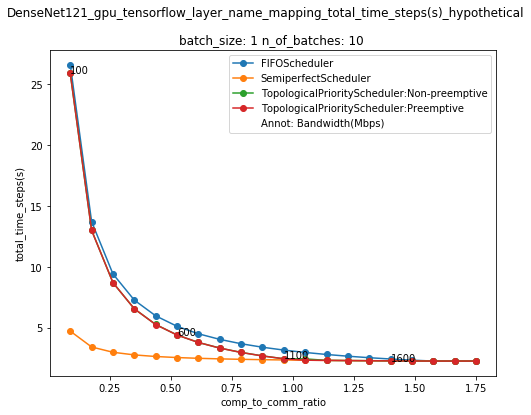

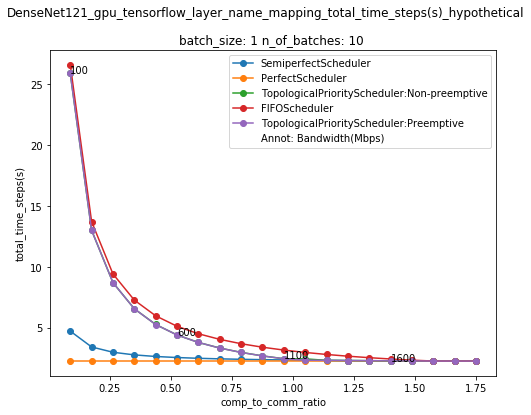

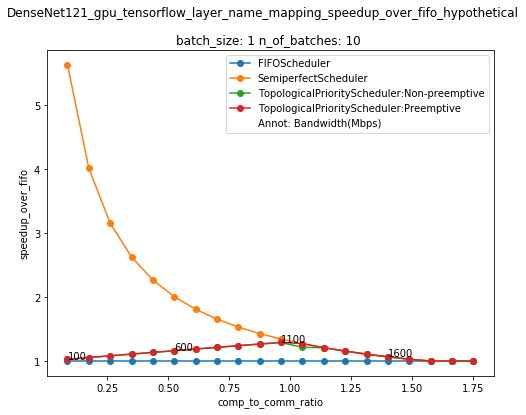

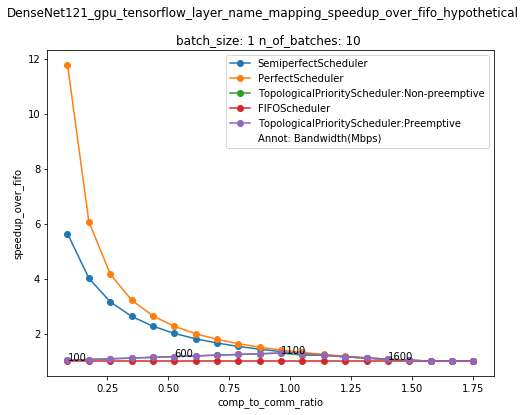

In [99]:
hypothetical_results = json.loads(json.dumps(summary["results"]))
add_hypothetical_perfect_scheduler(hypothetical_results)
add_hypothetical_semiperfect_scheduler(hypothetical_results)
add_network_scheduler_speedup_over_fifo(hypothetical_results)
sch_names = set(short_sch_names.keys())
sch_names.add("SemiperfectScheduler")
sch_names = [sch_names, sch_names.copy()]
sch_names[1].add("PerfectScheduler")
hypothetical_results["total_time_steps(s)"] = scale_time(hypothetical_results,"total_time_steps", "s")
for y in ["total_time_steps(s)", "speedup_over_fifo"]:
    for schs in sch_names:
        f = line_plot_grid(hypothetical_results, title="{}_{}_hypothetical".format(title, y), save=False,
                           x="comp_to_comm_ratio",
                           y=y,
                           line_variable=("network_scheduler", schs),
                           row_variable="batch_size",
                           column_variable="n_of_batches",
                           annotation_variable= "Bandwidth(Mbps)",
                           annotation_only_for_line_groups=["TopologicalPriorityScheduler:Preemptive"],
                           annotation_step=5,
                           label_length=float("inf"),
                           subplot_size=(8,6)
                          )
        file.savefig(f)

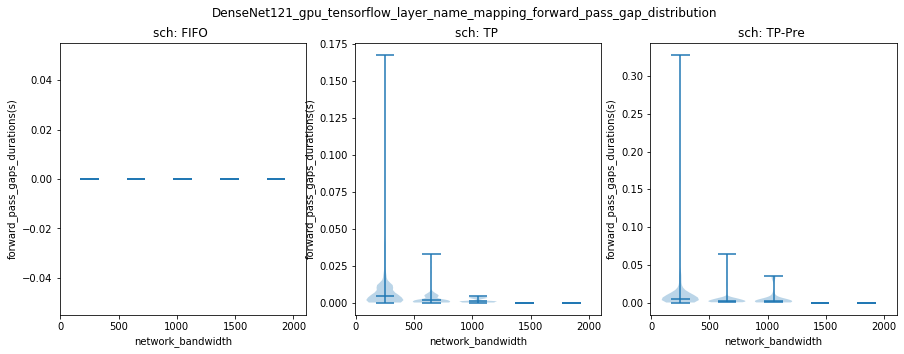

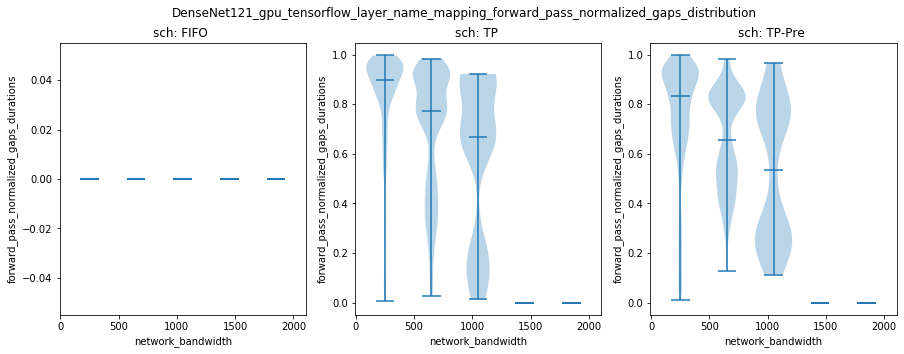

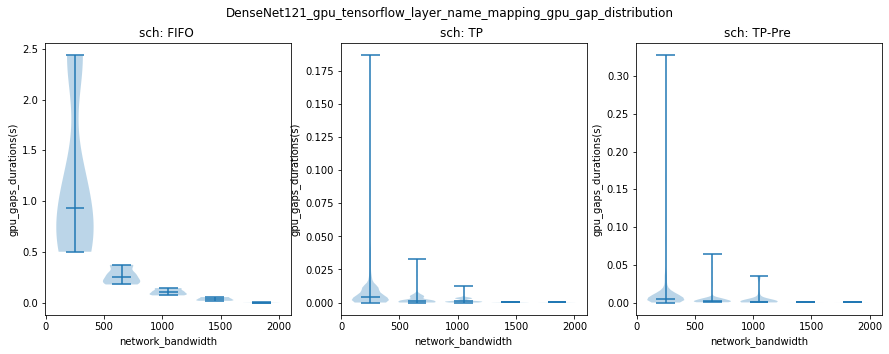

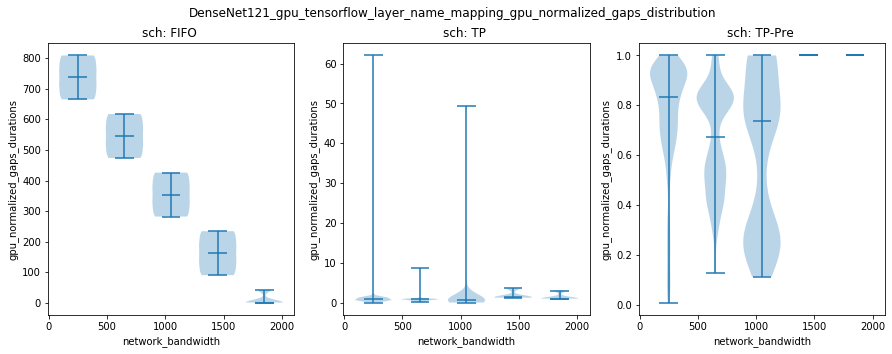

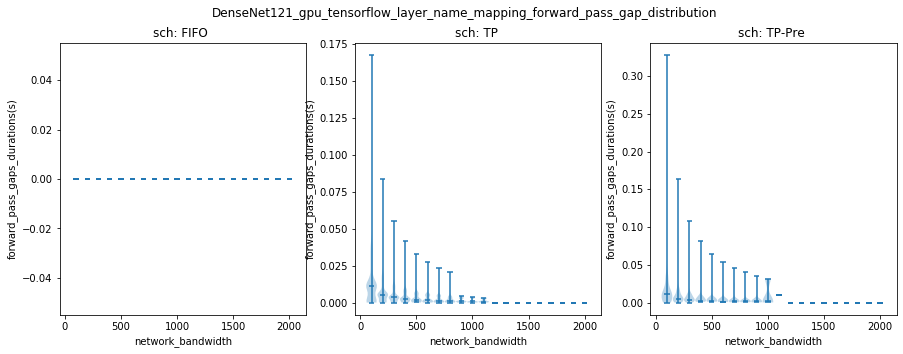

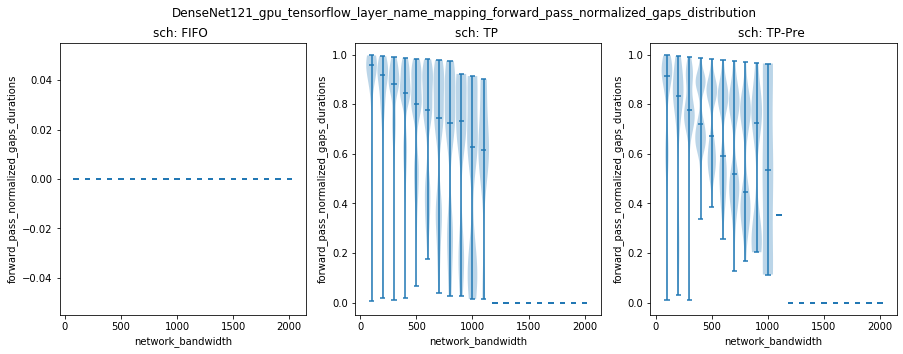

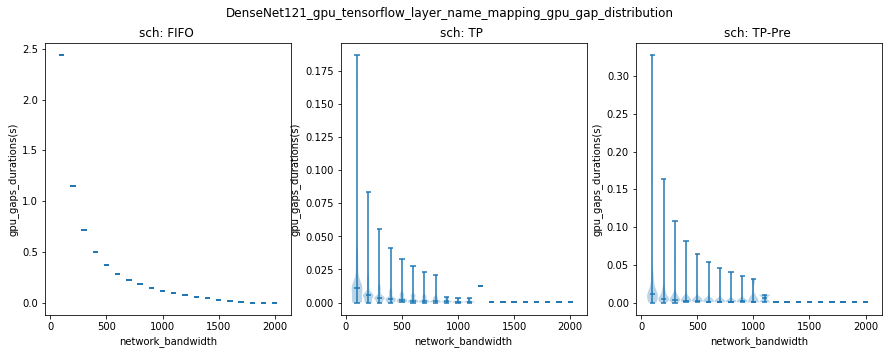

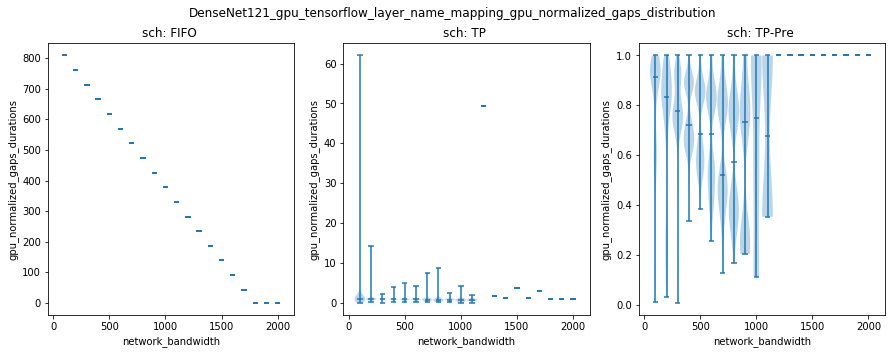

In [100]:
for bins in [5, None]:
    f = violin_plot_grid(summary["results"], x="network_bandwidth", y="forward_pass_gaps_durations(s)",
                         row_variable="sch", label_length=float("inf"), bins=bins,
                         title="{}_forward_pass_gap_distribution".format(title))
    file.savefig(f)
    f = violin_plot_grid(summary["results"], x="network_bandwidth", y="$list$forward_pass_normalized_gaps_durations",
                         row_variable="sch", label_length=float("inf"), bins=bins,
                         title="{}_forward_pass_normalized_gaps_distribution".format(title))
    file.savefig(f)
    f = violin_plot_grid(summary["results"], x="network_bandwidth", y="gpu_gaps_durations(s)",
                         row_variable="sch", label_length=float("inf"), bins=bins,
                         title="{}_gpu_gap_distribution".format(title))
    file.savefig(f)
    f = violin_plot_grid(summary["results"], x="network_bandwidth", y="$list$gpu_normalized_gaps_durations",
                         row_variable="sch", label_length=float("inf"), bins=bins,
                         title="{}_gpu_normalized_gaps_distribution".format(title))
    file.savefig(f)
file.close()